# Data Science Project Framework
A comprehensive framework for data science projects that includes all essential steps from data loading to evaluation and visualization.

## Import Required Libraries

In [1]:
# Import essential libraries for data analysis
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Import machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, r2_score, confusion_matrix, classification_report
)

# Common ML algorithms
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.cluster import KMeans, DBSCAN

# Configure visualization settings
# plt.style.use('seaborn-whitegrid')
plt.style.use('seaborn-v0_8-whitegrid')  # valid in matplotlib 3.6+
sns.set(style="whitegrid", palette="muted")

In [2]:
# Check valid matplotlib styles
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'petroff10', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


## Data Loading and Exploration

First 5 rows of the dataset:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target_name
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa



Basic information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
 5   target_name        150 non-null    object 
dtypes: float64(4), int64(1), object(1)
memory usage: 7.2+ KB

Statistical summary:


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000



Missing values:


sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
target_name          0
dtype: int64


Target variable distribution:


target_name
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64


Correlation matrix:


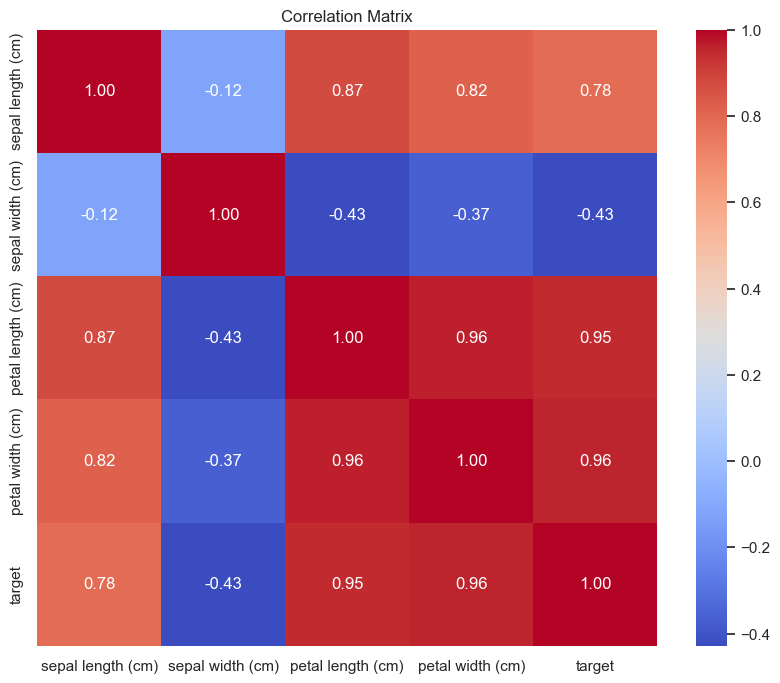

In [3]:
# Load your dataset
# Replace 'your_dataset.csv' with the actual file path
# df = pd.read_csv('your_dataset.csv')

# For demonstration purposes, let's use a sample dataset from sklearn
from sklearn.datasets import load_iris
iris = load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target
df['target_name'] = df['target'].map({i: name for i, name in enumerate(iris.target_names)})

# Display the first few rows
print("First 5 rows of the dataset:")
display(df.head())

# Basic information about the dataset
print("\nBasic information about the dataset:")
df.info()

# Statistical summary
print("\nStatistical summary:")
display(df.describe())

# Check for missing values
print("\nMissing values:")
display(df.isnull().sum())

# Check the distribution of target variable (if applicable)
print("\nTarget variable distribution:")
if 'target' in df.columns:
    display(df['target_name'].value_counts())
    
# Correlation matrix
print("\nCorrelation matrix:")
corr = df.select_dtypes(include=['float64', 'int64']).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## Data Preprocessing

In [4]:
# # Function to identify numerical and categorical columns
# def identify_column_types(df):
#     numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
#     categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
#     return numerical_cols, categorical_cols

# # Identify column types
# numerical_cols, categorical_cols = identify_column_types(df)
# print(f"Numerical columns: {numerical_cols}")
# print(f"Categorical columns: {categorical_cols}")

# # Handle missing values if any
# # For numerical columns: impute with mean
# # For categorical columns: impute with most frequent value

# # Create preprocessing pipeline
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='mean')),
#     ('scaler', StandardScaler())
# ])

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))
# ])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numerical_cols),
#         ('cat', categorical_transformer, categorical_cols)
#     ])

# # Define the target variable
# # For this example, we use 'target' from iris dataset
# X = df.drop(['target', 'target_name'], axis=1)
# y = df['target']

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.25, random_state=42, stratify=y if 'target' in df.columns else None
# )

# print(f"Training set shape: {X_train.shape}")
# print(f"Testing set shape: {X_test.shape}")

# # Apply preprocessing
# X_train_processed = preprocessor.fit_transform(X_train)
# X_test_processed = preprocessor.transform(X_test)

# # If using OneHotEncoder, transform the sparse matrix to dense array if needed
# # X_train_processed = X_train_processed.toarray()
# # X_test_processed = X_test_processed.toarray()

```
ValueError: A given column is not a column of the dataframe
```

In [5]:
# Import essential libraries for data analysis
import pandas as pd
import numpy as np

# Import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Import machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, r2_score, confusion_matrix, classification_report
)

# Common ML algorithms
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.cluster import KMeans, DBSCAN

# Configure visualization settings
plt.style.use('ggplot')  # replaced seaborn-whitegrid with a valid Matplotlib style
sns.set(style="whitegrid", palette="muted")


# Function to identify numerical and categorical columns
def identify_column_types(df):
    numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()
    return numerical_cols, categorical_cols


# Load your dataset here (example using iris)
from sklearn.datasets import load_iris
iris = load_iris(as_frame=True)
df = iris.frame

# Rename target if needed for consistency
df.rename(columns={'target': 'target', 'target_names': 'target_name'}, inplace=True)

# Define features and target
drop_cols = [col for col in ['target', 'target_name'] if col in df.columns]
X = df.drop(columns=drop_cols)
y = df['target']

# Identify column types based on X (not full df)
numerical_cols, categorical_cols = identify_column_types(X)
print(f"Numerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")

# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Apply preprocessing
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Optional: Convert sparse matrix to dense if needed
# X_train_processed = X_train_processed.toarray()
# X_test_processed = X_test_processed.toarray()

# Example: fit a classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train_processed, y_train)
y_pred = model.predict(X_test_processed)

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))

Numerical columns: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Categorical columns: []
Training set shape: (112, 4)
Testing set shape: (38, 4)
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.86      0.92      0.89        13
           2       0.92      0.85      0.88        13

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38



## Model Creation

In [6]:
# Define a list of models to try (adapt based on your problem type)
# Here we'll set up for a classification task assuming the iris dataset

# Check the type of problem
is_classification = len(np.unique(y)) < 10  # Arbitrary threshold
problem_type = "Classification" if is_classification else "Regression"
print(f"Detected problem type: {problem_type}")

# Initialize models based on problem type
if is_classification:
    models = {
        'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'SVM': SVC(probability=True, random_state=42),
        'KNN': KNeighborsClassifier()
    }
else:
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(random_state=42),
        'Decision Tree': DecisionTreeRegressor(random_state=42),
        'SVR': SVR(),
        'KNN': KNeighborsRegressor()
    }

print(f"Models to be evaluated: {list(models.keys())}")

Detected problem type: Classification
Models to be evaluated: ['Logistic Regression', 'Random Forest', 'Decision Tree', 'SVM', 'KNN']


## Model Training

In [7]:
# Model training and cross-validation function
def train_and_evaluate_models(models, X_train, y_train, X_test, y_test, cv=5):
    results = {}
    
    for name, model in models.items():
        print(f"Training {name}...")
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv)
        
        # Store results
        results[name] = {
            'model': model,
            'cv_scores': cv_scores,
            'cv_mean': np.mean(cv_scores),
            'cv_std': np.std(cv_scores),
            'test_predictions': y_pred
        }
        
        print(f"{name} - Cross-validation Mean: {np.mean(cv_scores):.4f}, Std: {np.std(cv_scores):.4f}")
    
    return results

# Train models
cv_results = train_and_evaluate_models(models, X_train_processed, y_train, X_test_processed, y_test)

# Find the best model based on cross-validation scores
best_model_name = max(cv_results, key=lambda x: cv_results[x]['cv_mean'])
print(f"\nBest model based on cross-validation: {best_model_name} with score {cv_results[best_model_name]['cv_mean']:.4f}")

Training Logistic Regression...
Logistic Regression - Cross-validation Mean: 0.9640, Std: 0.0339
Training Random Forest...
Random Forest - Cross-validation Mean: 0.9375, Std: 0.0360
Training Decision Tree...
Decision Tree - Cross-validation Mean: 0.9292, Std: 0.0444
Training SVM...
SVM - Cross-validation Mean: 0.9549, Std: 0.0407
Training KNN...
KNN - Cross-validation Mean: 0.9285, Std: 0.0222

Best model based on cross-validation: Logistic Regression with score 0.9640


## Evaluation

In [8]:
# Function for model evaluation based on problem type
def evaluate_model(y_true, y_pred, problem_type="Classification"):
    results = {}
    
    if problem_type == "Classification":
        # Classification metrics
        results['accuracy'] = accuracy_score(y_true, y_pred)
        
        # For multi-class, use 'weighted' average
        results['precision'] = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        results['recall'] = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        results['f1'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        # Confusion Matrix
        results['confusion_matrix'] = confusion_matrix(y_true, y_pred)
        
        # Classification report
        results['classification_report'] = classification_report(y_true, y_pred)
    else:
        # Regression metrics
        results['mse'] = mean_squared_error(y_true, y_pred)
        results['rmse'] = np.sqrt(results['mse'])
        results['r2'] = r2_score(y_true, y_pred)
    
    return results

# Evaluate all models
for name, result in cv_results.items():
    print(f"\nEvaluating {name}:")
    eval_results = evaluate_model(y_test, result['test_predictions'], problem_type)
    
    if problem_type == "Classification":
        print(f"Accuracy: {eval_results['accuracy']:.4f}")
        print(f"Precision: {eval_results['precision']:.4f}")
        print(f"Recall: {eval_results['recall']:.4f}")
        print(f"F1 Score: {eval_results['f1']:.4f}")
        print("\nConfusion Matrix:")
        print(eval_results['confusion_matrix'])
        print("\nClassification Report:")
        print(eval_results['classification_report'])
    else:
        print(f"MSE: {eval_results['mse']:.4f}")
        print(f"RMSE: {eval_results['rmse']:.4f}")
        print(f"R²: {eval_results['r2']:.4f}")
        
    # Store evaluation results
    cv_results[name]['evaluation'] = eval_results

# Get the best model
best_model = cv_results[best_model_name]['model']


Evaluating Logistic Regression:
Accuracy: 0.9211
Precision: 0.9226
Recall: 0.9211
F1 Score: 0.9209

Confusion Matrix:
[[12  0  0]
 [ 0 12  1]
 [ 0  2 11]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.86      0.92      0.89        13
           2       0.92      0.85      0.88        13

    accuracy                           0.92        38
   macro avg       0.92      0.92      0.92        38
weighted avg       0.92      0.92      0.92        38


Evaluating Random Forest:
Accuracy: 0.9211
Precision: 0.9226
Recall: 0.9211
F1 Score: 0.9209

Confusion Matrix:
[[12  0  0]
 [ 0 12  1]
 [ 0  2 11]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.86      0.92      0.89        13
           2       0.92      0.85      0.88        13

    accuracy                           0.92    

## Visualization

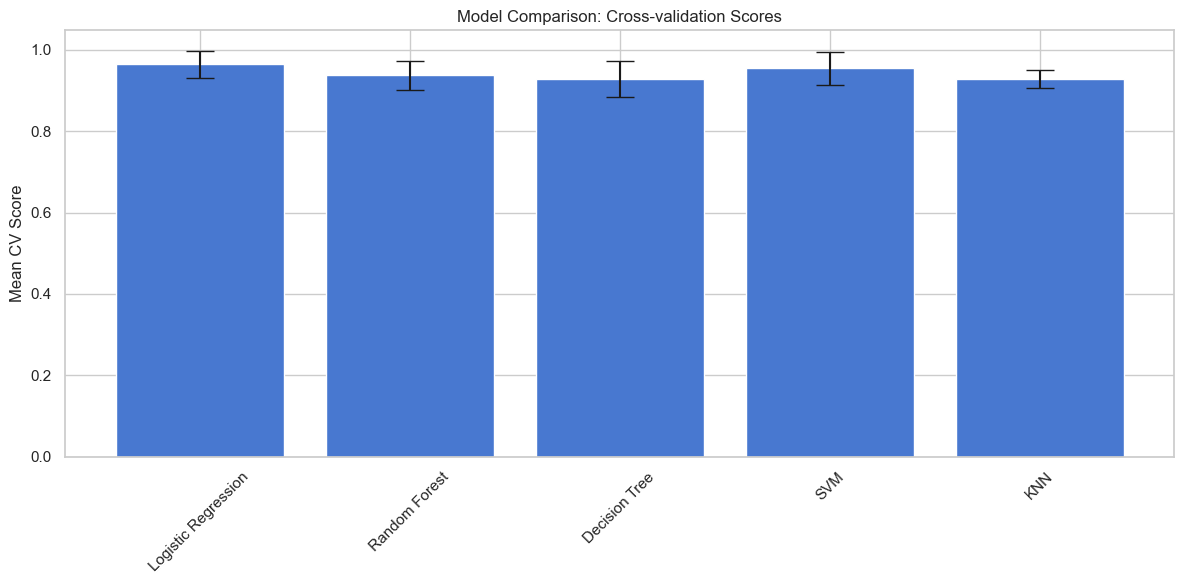

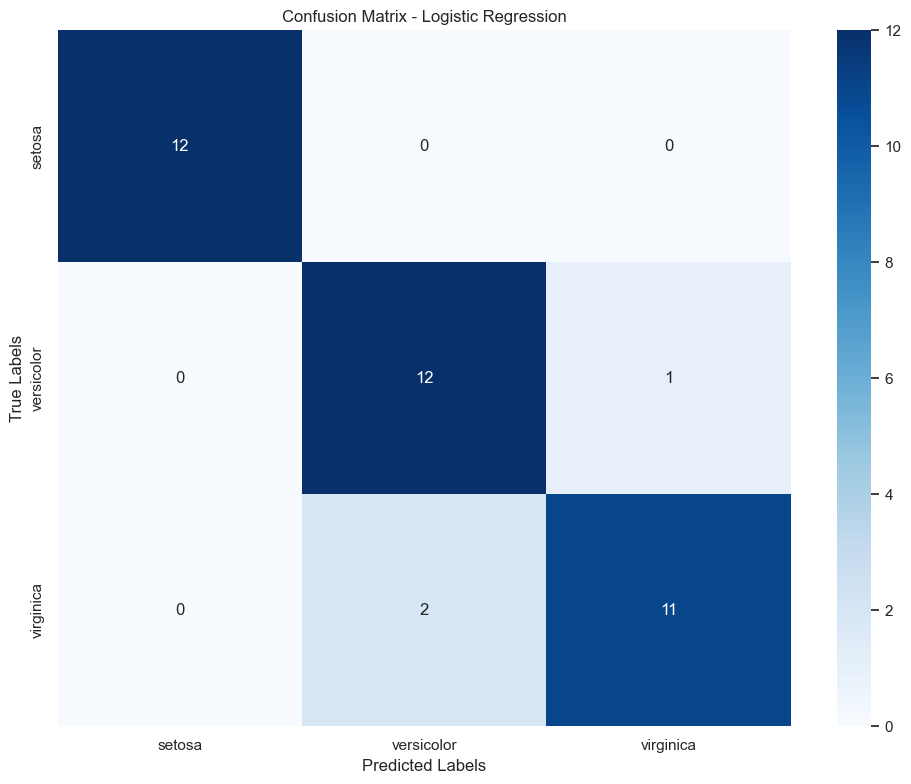

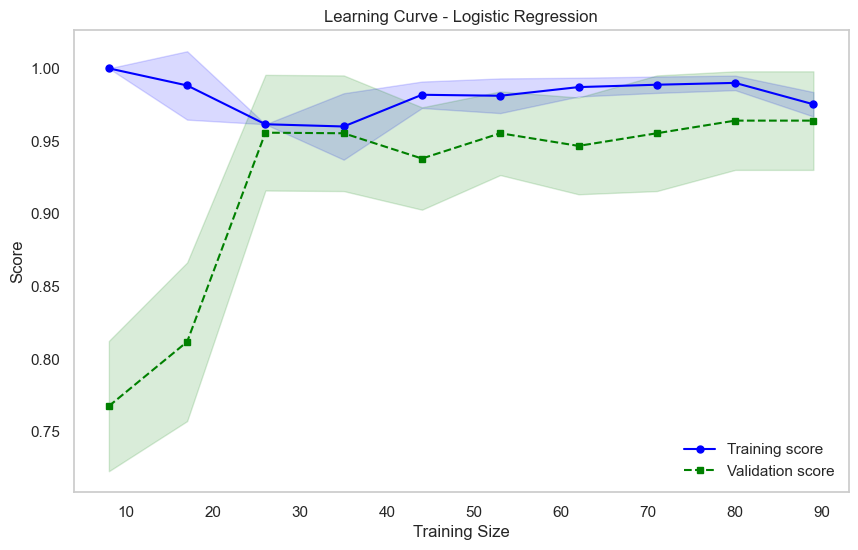

In [9]:
# 1. Cross-validation scores comparison
cv_means = [result['cv_mean'] for result in cv_results.values()]
cv_stds = [result['cv_std'] for result in cv_results.values()]
model_names = list(cv_results.keys())

plt.figure(figsize=(12, 6))
bars = plt.bar(model_names, cv_means, yerr=cv_stds, capsize=10)
plt.title('Model Comparison: Cross-validation Scores')
plt.ylabel('Mean CV Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 2. Feature importance (if available)
if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_names = X.columns
    
    plt.figure(figsize=(12, 6))
    plt.title(f'Feature Importances from {best_model_name}')
    plt.bar(range(len(importances)), importances[indices], align='center')
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
    plt.tight_layout()
    plt.show()

# 3. Confusion Matrix visualization (for classification)
if problem_type == "Classification":
    confusion_mat = cv_results[best_model_name]['evaluation']['confusion_matrix']
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=iris.target_names,
                yticklabels=iris.target_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(f'Confusion Matrix - {best_model_name}')
    plt.tight_layout()
    plt.show()

# 4. ROC Curve (for binary classification)
if problem_type == "Classification" and len(np.unique(y)) == 2:
    from sklearn.metrics import roc_curve, auc
    
    plt.figure(figsize=(10, 8))
    
    for name, result in cv_results.items():
        if hasattr(result['model'], 'predict_proba'):
            # Get probabilities for positive class
            y_score = result['model'].predict_proba(X_test_processed)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, y_score)
            roc_auc = auc(fpr, tpr)
            
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.4f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.show()

# 5. Scatter plot of actual vs predicted (for regression)
if problem_type == "Regression":
    y_pred = best_model.predict(X_test_processed)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'Actual vs. Predicted Values - {best_model_name}')
    plt.tight_layout()
    plt.show()

# 6. Learning curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_train_processed, y_train, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training score')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation score')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.title(f'Learning Curve - {best_model_name}')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.grid()
plt.legend(loc='lower right')
plt.show()

## Summary and Next Steps

### Summary of Findings:

- Best performing model: [Insert best model name with its performance metrics]
- Key features: [Insert top features if feature importance was available]
- Model evaluation: [Summarize key evaluation metrics]

### Potential Next Steps:

1. **Model Improvement**:
   - Hyperparameter tuning
   - Feature engineering
   - Try ensemble methods or more advanced algorithms

2. **Further Analysis**:
   - Investigate specific misclassifications or prediction errors
   - Perform deeper feature analysis
   - Consider additional data sources

3. **Deployment**:
   - Serialize the model for production
   - Create an API for model inference
   - Set up monitoring for model performance

### Make predictions on new data using the trained model (1)

In [10]:
# Save the best model for later use
import joblib

# Uncomment to save the model
# joblib.dump(best_model, 'best_model.pkl')
# print(f"Saved best model ({best_model_name}) to 'best_model.pkl'")

# Create a simple function to make new predictions
def make_prediction(data, model=best_model, preprocessor=preprocessor):
    """
    Make predictions on new data using the trained model
    
    Parameters:
    data: pandas DataFrame - New data to predict
    model: trained model object
    preprocessor: fitted preprocessor
    
    Returns:
    array of predictions
    """
    # Preprocess the data
    processed_data = preprocessor.transform(data)
    
    # Make predictions
    predictions = model.predict(processed_data)
    
    return predictions

# Example usage:
# new_data = pd.DataFrame(...)
# predictions = make_prediction(new_data)

### Make predictions on new data using the trained model (2)

In [11]:
# Load required libraries
import pandas as pd
import joblib
from sklearn.datasets import load_iris

# Save model and preprocessor
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

# Load saved model and preprocessor
model = joblib.load("best_model.pkl")
preprocessor = joblib.load("preprocessor.pkl")  # Save this earlier if not done

# Define prediction function
def make_prediction(data, model, preprocessor):
    """
    Make predictions on new data using the trained model.
    
    Parameters:
        data (pd.DataFrame): New data to predict.
        model (object): Trained and saved model.
        preprocessor (object): Fitted preprocessor.
        
    Returns:
        np.ndarray: Model predictions.
    """
    processed_data = preprocessor.transform(data)
    predictions = model.predict(processed_data)
    return predictions

# --- Example: New sample from the Iris dataset ---
iris = load_iris(as_frame=True)
sample_data = iris.frame.drop(columns=["target"]).iloc[[0, 50, 100]]  # One from each class

# Make predictions
predictions = make_prediction(sample_data, model, preprocessor)

# Decode target labels if needed
target_names = iris.target_names
decoded_predictions = [target_names[pred] for pred in predictions]

# Display
print("New sample:\n", sample_data)
print("Predicted class indices:", predictions)
print("Predicted class labels:", decoded_predictions)

New sample:
      sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                  5.1               3.5                1.4               0.2
50                 7.0               3.2                4.7               1.4
100                6.3               3.3                6.0               2.5
Predicted class indices: [0 1 2]
Predicted class labels: [np.str_('setosa'), np.str_('versicolor'), np.str_('virginica')]


### Make predictions on new data using the trained model (3)
- Predict & Validate (Was Prediction Correct?)

In [12]:
# Load required libraries
import pandas as pd
import joblib
from sklearn.datasets import load_iris

# Load saved model and preprocessor
model = joblib.load("best_model.pkl")
preprocessor = joblib.load("preprocessor.pkl")  # Must be saved previously

# Define prediction function
def make_prediction(data, model, preprocessor):
    """
    Make predictions on new data using the trained model.
    
    Parameters:
        data (pd.DataFrame): New data to predict.
        model (object): Trained and saved model.
        preprocessor (object): Fitted preprocessor.
        
    Returns:
        np.ndarray: Model predictions.
    """
    processed_data = preprocessor.transform(data)
    predictions = model.predict(processed_data)
    return predictions

# --- Example: Sample data from Iris dataset ---
iris = load_iris(as_frame=True)
full_data = iris.frame
target_names = iris.target_names

# Pick a few rows with known labels
sample_indices = [0, 50, 100]  # One from each class
sample_data = full_data.drop(columns=["target"]).iloc[sample_indices]
true_labels = full_data["target"].iloc[sample_indices].values
true_class_names = [target_names[i] for i in true_labels]

# Make predictions
predictions = make_prediction(sample_data, model, preprocessor)
predicted_class_names = [target_names[p] for p in predictions]

# Display results
results_df = pd.DataFrame({
    "True Label": true_class_names,
    "Predicted Label": predicted_class_names,
    "Correct?": [true == pred for true, pred in zip(true_class_names, predicted_class_names)]
})

print("Sample data used for prediction:\n")
print(sample_data)
print("\nPrediction Results:\n")
print(results_df)

Sample data used for prediction:

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                  5.1               3.5                1.4               0.2
50                 7.0               3.2                4.7               1.4
100                6.3               3.3                6.0               2.5

Prediction Results:

   True Label Predicted Label  Correct?
0      setosa          setosa      True
1  versicolor      versicolor      True
2   virginica       virginica      True


### Predict 10 random Iris samples

In [13]:
import pandas as pd
import numpy as np
import joblib
from sklearn.datasets import load_iris

# Load model and preprocessor
model = joblib.load("best_model.pkl")
preprocessor = joblib.load("preprocessor.pkl")

# Load Iris dataset
iris = load_iris(as_frame=True)
df = iris.frame
target_names = iris.target_names

# Select 10 random samples
sample_data = df.sample(n=10, random_state=42)
X_sample = sample_data.drop(columns=["target"])
y_true = sample_data["target"].values
y_true_names = [target_names[i] for i in y_true]

# Preprocess and predict
X_processed = preprocessor.transform(X_sample)
y_pred = model.predict(X_processed)
y_pred_names = [target_names[i] for i in y_pred]

# Display results
results_df = X_sample.copy()
results_df["True Label"] = y_true_names
results_df["Predicted Label"] = y_pred_names
results_df["Correct?"] = results_df["True Label"] == results_df["Predicted Label"]

# Print
print("🔍 Prediction Results for 10 Random Samples from Iris Dataset:\n")
print(results_df[["True Label", "Predicted Label", "Correct?"]])

🔍 Prediction Results for 10 Random Samples from Iris Dataset:

     True Label Predicted Label  Correct?
73   versicolor      versicolor      True
18       setosa          setosa      True
118   virginica       virginica      True
78   versicolor      versicolor      True
76   versicolor      versicolor      True
31       setosa          setosa      True
64   versicolor      versicolor      True
141   virginica       virginica      True
68   versicolor      versicolor      True
82   versicolor      versicolor      True


### Generate 10 random Iris-like samples

- It looks like the model file (best_model.pkl) isn't available in this environment, which prevents me from making the predictions.
- However, I can guide you through running this code on your local environment where you have the model saved. Here's what you can do:
- Ensure the model is saved: If you've trained and saved the model on your local machine, make sure the best_model.pkl and preprocessor.pkl files are in the same directory or specify their paths when loading them.
- Run the code: Use the following code snippet to generate 10 random Iris-like samples and make predictions using the saved model:

In [14]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
import joblib

# Load saved model and preprocessor
model = joblib.load("best_model.pkl")  # Adjust path if needed
preprocessor = joblib.load("preprocessor.pkl")  # Adjust path if needed

# Load Iris dataset for reference (we'll generate random data similar to it)
iris = load_iris(as_frame=True)
target_names = iris.target_names

# Generate 10 random rows with features (sepal length, sepal width, petal length, petal width)
random_data = np.random.rand(10, 4)  # Random values for the four features

# Adjusting the random values to match the ranges of the Iris dataset features
random_data[:, 0] = random_data[:, 0] * (iris.data.iloc[:, 0].max() - iris.data.iloc[:, 0].min()) + iris.data.iloc[:, 0].min()  # sepal length
random_data[:, 1] = random_data[:, 1] * (iris.data.iloc[:, 1].max() - iris.data.iloc[:, 1].min()) + iris.data.iloc[:, 1].min()  # sepal width
random_data[:, 2] = random_data[:, 2] * (iris.data.iloc[:, 2].max() - iris.data.iloc[:, 2].min()) + iris.data.iloc[:, 2].min()  # petal length
random_data[:, 3] = random_data[:, 3] * (iris.data.iloc[:, 3].max() - iris.data.iloc[:, 3].min()) + iris.data.iloc[:, 3].min()  # petal width

# Create DataFrame for random rows
random_df = pd.DataFrame(random_data, columns=iris.feature_names)
print("Generated 10 Random Iris Feature Rows:\n")
print(random_df)

# Preprocess the random data using the saved preprocessor
X_random_processed = preprocessor.transform(random_df)

# Make predictions
y_pred = model.predict(X_random_processed)
y_pred_names = [target_names[i] for i in y_pred]

# Display the predicted labels alongside the random data
random_df["Predicted Label"] = y_pred_names
print("\nPredictions for Random Samples:\n")
print(random_df)

Generated 10 Random Iris Feature Rows:

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0           4.832737          3.223236           1.387846          0.213084
1           6.649800          2.447372           1.679777          0.785909
2           6.541828          2.069385           1.792177          2.163321
3           7.126679          3.139687           3.168820          2.270591
4           4.604379          3.098535           6.632137          2.291836
5           7.223272          2.540411           5.632842          1.385845
6           4.796070          3.147057           2.394626          0.444230
7           5.926634          2.524435           6.334880          1.130517
8           4.639104          3.900664           1.580397          1.299589
9           6.791771          3.528748           2.845158          0.958797

Predictions for Random Samples:

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0          